In [20]:
import matplotlib.pyplot as plt
import os
import pickle
import json
import jax
import jax.numpy as jnp
import numpy as np

os.environ["CUDA_VISIBLE_DEVICES"] = ""

import sys

sys.path.append("..")

from tRLwLLM.environment import BabyAI
from tRLwLLM.utils import Transition
from tRLwLLM.model import ExtractObs, KeyExtractor, ActorCriticRNN, ScannedRNN

# Training curves

In [2]:
log = "logs_rl"

expe = "20240717_191230"
n_updates = 102

with open(
    os.path.join("..", log, expe, f"training_metrics_{n_updates}.pkl"), "rb"
) as file:
    training_metrics = pickle.load(file)

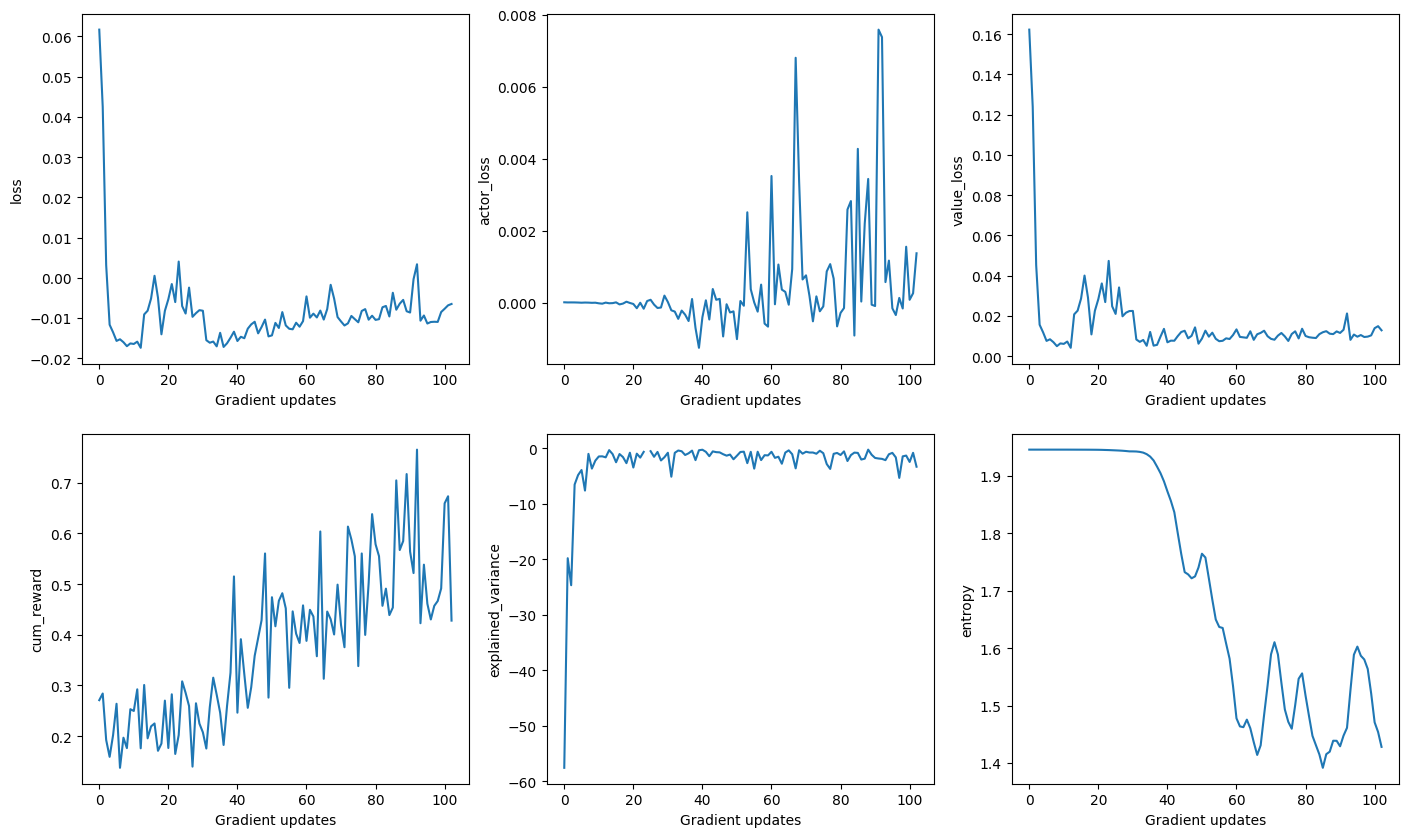

In [27]:
n_keys = len(training_metrics.keys())
n_cols = 3
n_rows = (n_keys + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(17, 10))

axes = axes.flatten()

for ii, (key, value) in enumerate(training_metrics.items()):
    ax = axes[ii]
    ax.plot(value)
    ax.set_xlabel("Gradient updates")
    ax.set_ylabel(key)

for jj in range(ii + 1, len(axes)):
    fig.delaxes(axes[jj])

plt.show()

# Trained policy

In [3]:
log = "logs_rl"

expe = "20240717_191230"
n_updates = 102

with open(os.path.join("..", log, expe, "args.json"), "r") as file:
    training_args = json.load(file)

with open(os.path.join("..", log, expe, f"params_{n_updates}.pkl"), "rb") as file:
    params = pickle.load(file)

CUDA backend failed to initialize: jaxlib/cuda/versions_helpers.cc:99: operation cuInit(0) failed: CUDA_ERROR_UNKNOWN.(Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [18]:
training_args["num_envs"] = 1
env = BabyAI(training_args)

/home/chetouani/miniforge-pypy3/envs/tRLwLLM/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [16]:
extractor = ExtractObs(training_args)
feature_extractor = KeyExtractor
feature_extractor_kwargs = training_args["feature_extractor_kwargs"]

network = ActorCriticRNN(
    action_dim=1,
    discrete=True,
    feature_extractor_class=feature_extractor,
    feature_extractor_kwargs=feature_extractor_kwargs,
    num_action=env.action_space.n,
    num_components=None,
)

feature_extractor_shape = training_args["feature_extractor_kwargs"][
    "final_hidden_layers"
]
init_rnn_state = init_rnn_state_train = ScannedRNN.initialize_carry(
    (training_args["num_envs"], feature_extractor_shape)
)

In [9]:
def extand(x):
    if isinstance(x, jnp.ndarray):
        return x[jnp.newaxis, ...]
    else:
        return


def _env_step(runner_state):
    train_state, last_obsv, last_done, rnn_state, rng = runner_state

    # SELECT ACTION
    ac_in = (jax.tree_map(extand, last_obsv), last_done[np.newaxis, :])
    rnn_state, pi, value = network.apply(train_state.params, rnn_state, ac_in)

    rng, rng_sample_action = jax.random.split(rng)
    action = pi.sample(seed=rng_sample_action)
    log_prob = pi.log_prob(action).squeeze(-1)
    value, action, log_prob = (
        value.squeeze(0),
        action.squeeze(0),
        log_prob.squeeze(0),
    )

    # STEP ENV
    obs, reward, done, info = env.step(action)
    obsv = extractor(obs)

    transition = Transition(last_done, action, value, reward, log_prob, last_obsv, info)
    runner_state = (train_state, obsv, done, rnn_state, rng)
    return runner_state, transition

In [ ]:
rng = jax.random.PRNGKey(42)

obs, done = env.reset()
obsv = extractor(obs)

rnn_state = init_rnn_state

while not (done or env.step_count > env.max_steps):
    # SELECT ACTION
    ac_in = (jax.tree_map(extand, obsv), done[np.newaxis, :])
    rnn_state, pi, value = network.apply(params, rnn_state, ac_in)

    rng, rng_sample_action = jax.random.split(rng)
    action = pi.sample(seed=rng_sample_action)
    log_prob = pi.log_prob(action).squeeze(-1)
    value, action, log_prob = (
        value.squeeze(0),
        action.squeeze(0),
        log_prob.squeeze(0),
    )

    # STEP ENV
    obs, reward, done, info = env.step(action)
    obsv = extractor(obs)

    plt.imshow(env.render())